In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

In [59]:
def extend(a, b):
    return 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a

stype = 'pca'
pd.set_option('display.width', 200)
data = pd.read_csv('iris.data', header=None)
#columns = np.array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type'])
columns = np.array(['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度', '类型'])
data.rename(columns = dict(list(zip(np.arange(5), columns))), inplace = True)    #修改data列名并替换
data['类型'] = pd.Categorical(data['类型']).codes 
x = data[columns[:-1]]
y = data[columns[-1]]
display(data.head())
display(x.head())
display(y.head())
set(data['类型'])

,花萼长度,花萼宽度,花瓣长度,花瓣宽度,类型
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,花萼长度,花萼宽度,花瓣长度,花瓣宽度
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


0    0
1    0
2    0
3    0
4    0
Name: 类型, dtype: int8

{0, 1, 2}

In [57]:
if stype == 'pca':
    pca = PCA(n_components = 2, whiten = True, random_state = 0)     #保留2个主成分，白化(归一化)
    x = pca.fit_transform(x)                                         #用x训练PCA并返回降维后的数据
    print('各方向方差：', pca.explained_variance_)                     #保留的n个成分各自的方差
    print('方差所占比例：', pca.explained_variance_ratio_)
    x1_label, x2_label = 'comp1', 'comp2'
    title = 'PCA'
else:
    fs = SelectKBest(chi2, k = 2)
    fs.fit(x, y)
    idx = fs.get_support(indices = True)
    print('fs.get_support() = ', idx)
    x = x[columns[idx]]
    x = x.values                                                     # 为下面使用方便，DataFrame转换成ndarray
    x1_label, x2_label = columns[idx]
    title = 'Feature'

各方向方差： [1.12873999 0.88835868]
方差所占比例： [0.55958591 0.44041409]


[[-1.3059028   0.66358991]
 [-1.32107398 -0.34449998]
 [-1.405936   -0.27905426]
 [-1.33617856 -0.63213207]
 [-1.32749711  0.67845686]]


/Users/lee_excited/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


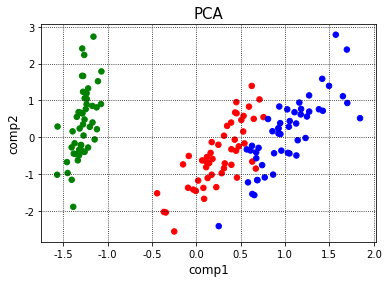

In [53]:
print(x[ : 5])
cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])

plt.figure(facecolor = 'w')
plt.scatter(x[:, 0], x[:, 1], s = 30, c = y, marker = 'o', cmap = cm_dark)
plt.grid(b = True, ls = ':', color = 'k')
plt.xlabel(x1_label, fontsize = 12)
plt.ylabel(x2_label, fontsize = 12)
plt.title(title, fontsize = 15)
plt.show()


In [54]:
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.3)
model = Pipeline([
    ('poly', PolynomialFeatures(degree = 2, include_bias = True)),
    ('lr', LogisticRegressionCV(Cs = np.logspace(-3, 4, 8), cv = 5, fit_intercept = False))
])
model.fit(x, y)
print('最优参数', model.get_params('lr')['lr'].C_)
y_hat = model.predict(x)
print('训练级精度：', metrics.accuracy_score(y, y_hat))
y_test_hat = model.predict(x_test)
print('测试集精度：', metrics.accuracy_score(y_test, y_test_hat))

最优参数 [1.e-02 1.e+00 1.e+02]
训练级精度： 0.9523809523809523
测试集精度： 1.0


/Users/lee_excited/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


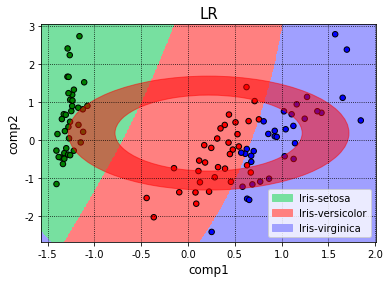

In [55]:
N, M = 500, 500
x1_min, x1_max = extend(x[:, 0].min(), x[:, 0].max())    #第1个主成分——extend
x2_min, x2_max = extend(x[:, 1].min(), x[:, 1].max())    #第2个主成分——extend
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)                             #生成网格采样点
x_show = np.stack((x1.flat, x2.flat), axis = 1)          #测试点
y_hat = model.predict(x_show)                            #预测值
y_hat = y_hat.reshape(x1.shape)                          #与输入形状相同
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_hat, cmap = cm_light)           #预测值显示
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, edgecolors='k', cmap=cm_dark)  # 样本绘制
plt.xlabel(x1_label, fontsize = 12)
plt.ylabel(x2_label, fontsize = 12)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid(b=True, ls=':', color='k')
a = mpl.patches.Wedge(((x1_min+x1_max)/2, (x2_min+x2_max)/2), 1.5, 0, 360, width=0.5, alpha=0.5, color='r')
plt.gca().add_patch(a)
patchs = [mpatches.Patch(color='#77E0A0', label='Iris-setosa'),
          mpatches.Patch(color='#FF8080', label='Iris-versicolor'),
          mpatches.Patch(color='#A0A0FF', label='Iris-virginica')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8, loc='lower right')
plt.title('LR', fontsize=15)
plt.show()


In [60]:
fs = SelectKBest(chi2, k = 2)
fs.fit(x, y)
idx = fs.get_support(indices = True)
print('fs.get_support() = ', idx)
x = x[columns[idx]]
x = x.values                                                     # 为下面使用方便，DataFrame转换成ndarray
x1_label, x2_label = columns[idx]
title = 'Feature'

x, x_test, y, y_test = train_test_split(x, y, test_size = 0.3)
model = Pipeline([
    ('poly', PolynomialFeatures(degree = 2, include_bias = True)),
    ('lr', LogisticRegressionCV(Cs = np.logspace(-3, 4, 8), cv = 5, fit_intercept = False))
])
model.fit(x, y)
print('最优参数', model.get_params('lr')['lr'].C_)
y_hat = model.predict(x)
print('训练级精度：', metrics.accuracy_score(y, y_hat))
y_test_hat = model.predict(x_test)
print('测试集精度：', metrics.accuracy_score(y_test, y_test_hat))

fs.get_support() =  [2 3]
最优参数 [  0.1 100.    1. ]
训练级精度： 0.9809523809523809
测试集精度： 0.9111111111111111


/Users/lee_excited/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


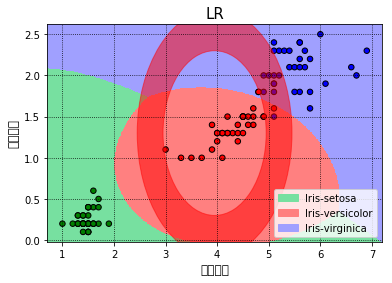

In [61]:
N, M = 500, 500
x1_min, x1_max = extend(x[:, 0].min(), x[:, 0].max())    #第1个主成分——extend
x2_min, x2_max = extend(x[:, 1].min(), x[:, 1].max())    #第2个主成分——extend
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)                             #生成网格采样点
x_show = np.stack((x1.flat, x2.flat), axis = 1)          #测试点
y_hat = model.predict(x_show)                            #预测值
y_hat = y_hat.reshape(x1.shape)                          #与输入形状相同
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_hat, cmap = cm_light)           #预测值显示
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, edgecolors='k', cmap=cm_dark)  # 样本绘制
plt.xlabel(x1_label, fontsize = 12)
plt.ylabel(x2_label, fontsize = 12)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid(b=True, ls=':', color='k')
a = mpl.patches.Wedge(((x1_min+x1_max)/2, (x2_min+x2_max)/2), 1.5, 0, 360, width=0.5, alpha=0.5, color='r')
plt.gca().add_patch(a)
patchs = [mpatches.Patch(color='#77E0A0', label='Iris-setosa'),
          mpatches.Patch(color='#FF8080', label='Iris-versicolor'),
          mpatches.Patch(color='#A0A0FF', label='Iris-virginica')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8, loc='lower right')
plt.title('LR', fontsize=15)
plt.show()
